# Detect and track LKFs in netcdf model output

This tutorial shows how to generate a LKF data-set based on gridded sea ice model output in netcdf format. It follows the methodolgy of the Sea Ice Rheology Experiment and details can be found in the [preprint](https://www.essoar.org/doi/10.1002/essoar.10507396.1). 

The netcdf file needs to follow the SIREx naming conventions that are described in detail in the [SIREx model output repository](https://doi.org/10.5281/zenodo.5555329). The required fields are:
1. dimensions:
   - time dimension named `time`
   - x dimension
   - y dimension
2. variables:
   - longitude named `lon` (x,y)
   - latitude named `lat` (x,y)
   - sea-ice velocity in x-direction named `U` (time,x,y)
   - sea-ice velocity in y-direction named `V` (time,x,y)
   - sea-ice concentration named `A` (time,x,y)
   
### Load `lkf_tools` package

In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from pathlib import Path
from lkf_tools.dataset import *

### Open netcdf file

We open the netcdf file with xarray. As an example we use here a simulation with the McGill model that is downloaded from the [SIREx model repository](https://zenodo.org/record/5555329/files/McGill_e2_1997_daily_means.zip?download=1) to the `../data/McGill/` directory. The zip-file is 170 MB large and the extracted netcdf 340 MB, so this might a few seconds.

In [5]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

datadir = Path('../data/McGill')
if not datadir.is_dir(): os.mkdir(datadir)

url = 'https://zenodo.org/record/5555329/files/McGill_e2_1997_daily_means.zip?download=1'
http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path=datadir)

### Open a new processing object
This step initiates a lkf processing object that reads in the netcdf files and sets everything up to run the detection and processing steps.

In [24]:
lkf_data = process_dataset('../data/McGill/McGill_e2_1997_daily_means.nc',
                           output_path='../data/lkfs/McGill/')

### Detection of LKFs
After initialising the lkf processing object, we run the detection step. If `indexes` is defined only those specific time steps will be detected. Here we just detect the first two days for demonstration purposes.

*Note: the algorithms currently outputs a number of warnings, that can be ignored mostly. It is an open issue to remove those warnings.*

In [25]:
lkf_data.detect_lkfs(indexes=[0,1])

Compute deformation rates and detect features for day 1
Start detection routines


/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:96: RuntimeWarning: invalid value encountered in true_divide
  gaussian_field = field_nonnan_f/mask_nan_f
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:1143: RuntimeWarning: Mean of empty slice
  eps_tot = np.nanmean(np.stack(eps_tot),axis=0)
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:243: RuntimeWarning: invalid value encountered in true_divide
  dx = (seg_active[:,:,-1]-seg_active[np.arange(seg_active.shape[0]),:,-num_points])/np.stack([num_points-1,num_points-1],axis=1) - (seg_append-seg_active[:,:,-1])
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:561: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(angle)/np.pi*180
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:557: RuntimeWarning: invalid value encountered in true_divide
  f1 = (f1/np.sqrt(np.sum(f1**2))) # Normalize basis vector
/Users/nhutter/Documents/R

Compute deformation rates and detect features for day 2
Start detection routines


/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:96: RuntimeWarning: invalid value encountered in true_divide
  gaussian_field = field_nonnan_f/mask_nan_f
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:1143: RuntimeWarning: Mean of empty slice
  eps_tot = np.nanmean(np.stack(eps_tot),axis=0)
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:243: RuntimeWarning: invalid value encountered in true_divide
  dx = (seg_active[:,:,-1]-seg_active[np.arange(seg_active.shape[0]),:,-num_points])/np.stack([num_points-1,num_points-1],axis=1) - (seg_append-seg_active[:,:,-1])
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:561: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(angle)/np.pi*180
/Users/nhutter/Documents/Research/lkf_tools/lkf_tools/detection.py:554: RuntimeWarning: invalid value encountered in true_divide
  e1 = (e1/np.sqrt(np.sum(e1**2))) # Normalize basis vector
/Users/nhutter/Documents/R

Now we can have a short look at the outcome of the detection. We will plot the LKFs detected in the last time step over the deformation rates.

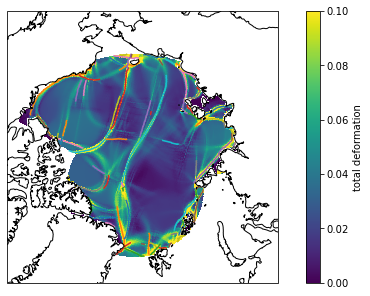

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[10, 5])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              np.sum(lkf_data.eps_tot_list,axis=0),transform=ccrs.PlateCarree(),vmin=0,vmax=1e-1)

it = lkf_data.indexes[-1]

#lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_McGill_runno01_expno07_1997_daily_means_029.npy'),allow_pickle=True)
lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)

for ilkf in lkfs:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],transform=ccrs.PlateCarree())

plt.colorbar(pcm,label='total deformation')

### Track LKFs

After detecting LKFs, we can track LKFs using the drift fields to advect features. Since we only detected two time steps, we can just track the first pair, which we define with `indexes` again.

In [27]:
lkf_data.track_lkfs(indexes=[0])

Track features in lkf_McGill_e2_1997_daily_means_001.npy to lkf_McGill_e2_1997_daily_means_002.npy


After tracking the features, we will plot the tracked results to see if it worked appropriately.

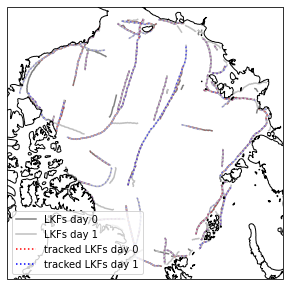

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[10, 5])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

it = 0

lkfs0 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)
lkfs1 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+2))),allow_pickle=True)

tracks = np.load(lkf_data.track_output_path.joinpath('lkf_tracked_pairs_%s_to_%s.npy' %(lkf_data.lkf_filelist[it][4:-4],
                                                                                        lkf_data.lkf_filelist[it+1][4:-4])),allow_pickle=True)

for ilkf in lkfs0:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.5',transform=ccrs.PlateCarree())
    
for ilkf in lkfs1:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.75',transform=ccrs.PlateCarree())

for itrack in tracks:
    ax.plot(lkfs0[itrack[0]][:,2],lkfs0[itrack[0]][:,3],'r:',alpha=0.25,transform=ccrs.PlateCarree())
    ax.plot(lkfs1[itrack[1]][:,2],lkfs1[itrack[1]][:,3],'b:',alpha=0.25,transform=ccrs.PlateCarree())
    
ax.plot([0,0],[0,0],'0.5',label='LKFs day 0')
ax.plot([0,0],[0,0],'0.75',label='LKFs day 1')
ax.plot([0,0],[0,0],'r:',label='tracked LKFs day 0')
ax.plot([0,0],[0,0],'b:',label='tracked LKFs day 1')

ax.legend()